In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session
TRAIN_PATH_FOLDER = '/kaggle/input/animals/animals/train'
VALIDATION_PATH_FOLDER = '/kaggle/input/animals/animals/val'


In [2]:
!pip install livelossplot

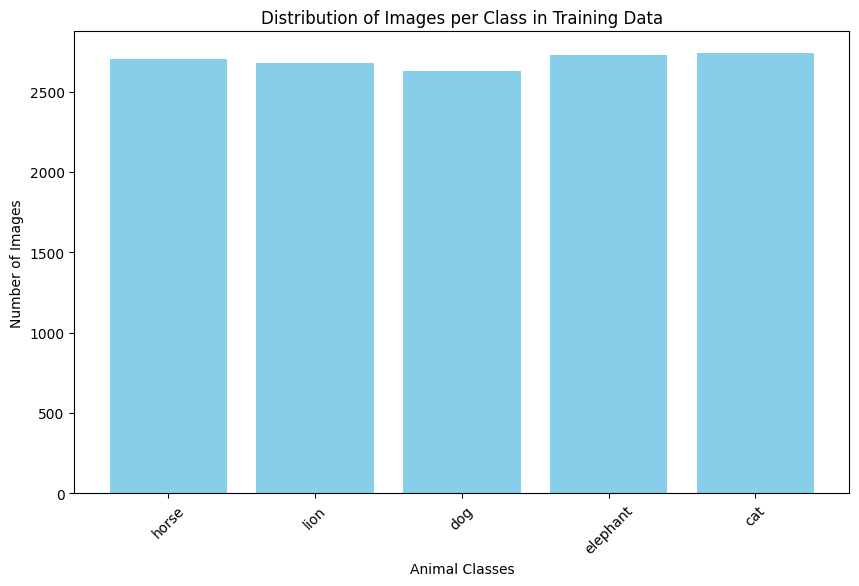

In [3]:
from collections import defaultdict
import matplotlib.pyplot as plt

training_len = defaultdict(int)  
for root, dirs, files in os.walk(TRAIN_PATH_FOLDER):
    if root == TRAIN_PATH_FOLDER:
        continue
    class_name = os.path.basename(root) 
    training_len[class_name] = len(files) 

classes = list(training_len.keys())
counts = list(training_len.values())

# Plotting
plt.figure(figsize=(10, 6))
plt.bar(classes, counts, color='skyblue')
plt.xlabel('Animal Classes')
plt.ylabel('Number of Images')
plt.title('Distribution of Images per Class in Training Data')
plt.xticks(rotation=45) 
plt.show()

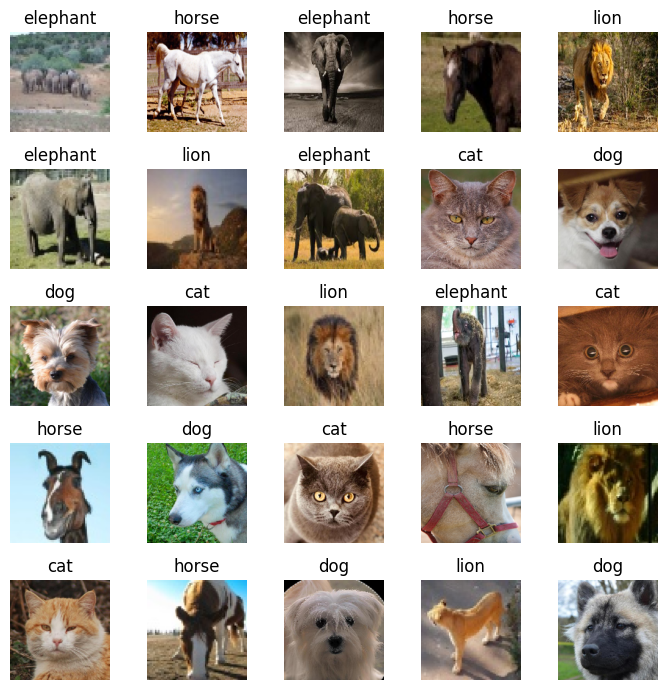

In [14]:
def show_images(base_path, classes, n=5):
    fig, axs = plt.subplots(5, 5, figsize=(7, 7))  # Adjust the size as needed
    axs = axs.flatten()
    
    selected_images = []
    for class_name in classes:
        class_path = os.path.join(base_path, class_name)
        image_files = os.listdir(class_path)
        selected_images.extend([(class_name, os.path.join(class_path, img)) for img in random.sample(image_files, n)])
    
    random.shuffle(selected_images)
    
    for ax, (class_name, img_path) in zip(axs, selected_images):
        img = load_img(img_path, target_size=(224, 224))
        ax.imshow(img)
        ax.set_title(class_name)
        ax.axis('off')
    
    plt.tight_layout()
    plt.show()
show_images(TRAIN_PATH_FOLDER, classes)

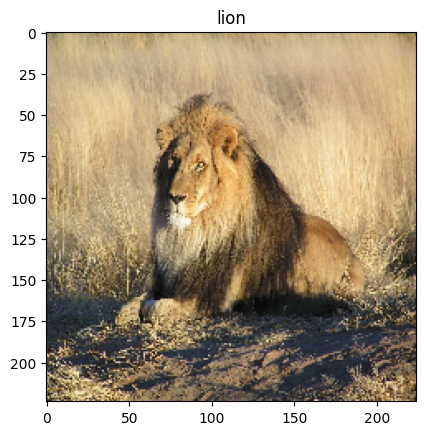

In [15]:
import random
from keras.preprocessing.image import load_img
def show_img(img_path: str, title: str):
  img = load_img(img_path, target_size= (224, 224))
  plt.imshow(img)
  plt.title(title)
  plt.show()
animal = random.choice(classes)
image_name = animal + f"{random.randint(3, 9)}.jpg"
image_path = os.path.join(TRAIN_PATH_FOLDER, animal, image_name)
show_img(image_path, animal)

In [16]:
from tensorflow.config.experimental import list_physical_devices
physical_devices = list_physical_devices('GPU')
print(f"Number of GPU: {len(physical_devices)}")

Number of GPU: 1


In [17]:
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
base_model = ResNet50(weights=None, include_top=False, input_shape=(224, 224, 3))  # No pretrained weights
base_model.summary()

Model: "resnet50"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer_1[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 23,534,592 (89.78 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [18]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator as Generator
from tensorflow.keras.applications.resnet import ResNet50, preprocess_input
import cv2

def apply_clahe(image):
    # Convert the image from BGR to LAB color space
    lab = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
    
    # Split the LAB image to L, A, and B channels
    l, a, b = cv2.split(lab)
    
    # Apply CLAHE to L channel
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    cl = clahe.apply(l)
    
    # Merge the CLAHE enhanced L channel with the A and B channels
    limg = cv2.merge((cl,a,b))
    
    # Convert the image from LAB back to BGR color space
    enhanced_img = cv2.cvtColor(limg, cv2.COLOR_LAB2BGR)
    
    return enhanced_img

train_datagen = Generator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
#     preprocessing_function=apply_clahe 

)
train_generator = train_datagen.flow_from_directory(
    TRAIN_PATH_FOLDER,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    color_mode = 'rgb',
    shuffle = True,
)

validation_datagen = Generator(rescale=1./255)
validation_generator = validation_datagen.flow_from_directory(
    VALIDATION_PATH_FOLDER,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    color_mode = 'rgb',
    shuffle = True,
)



Found 13474 images belonging to 5 classes.
Found 1497 images belonging to 5 classes.


In [19]:
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout


x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu')(x)
predictions = Dense(5, activation='softmax')(x)

model = Model(inputs=base_model.input,
              outputs=predictions)
model.summary()


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer_1[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 26,213,253 (100.00 MB)

 Trainable params: 26,160,133 (99.79 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [ ]:
from tensorflow.keras.callbacks import LearningRateScheduler
from livelossplot import PlotLossesKerasTF
from tensorflow.keras.callbacks import ModelCheckpoint

from tensorflow.keras.callbacks import EarlyStopping
model_name = 'resnet'
early_stopping =  EarlyStopping(
        monitor='val_loss',
        min_delta=1e-8,
        patience=10, 
        restore_best_weights=True,
        verbose=1)

model_checkpoint = ModelCheckpoint(
        filepath=f'{model_name}.weights.h5',
        monitor='val_loss',
        save_best_only=True,
        save_weights_only=True,
        verbose=1)



model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy', 'f1_score', 'precision', 'recall'])

def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * np.exp(-0.1)

lr_scheduler = LearningRateScheduler(scheduler)

history = model.fit(
    train_generator,
#     steps_per_epoch=train_generator.samples // train_generator.batch_size,
#     validation_steps=validation_generator.samples // validation_generator.batch_size,

    epochs=50,  # You can adjust the number of epochs
    validation_data=validation_generator,
    callbacks=[lr_scheduler, early_stopping, model_checkpoint]
)


Epoch 1/50


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


  1/422 ━━━━━━━━━━━━━━━━━━━━ 7:11:00 61s/step - accuracy: 0.1875 - f1_score: 0.1469 - loss: 2.0011 - precision: 0.1429 - recall: 0.0312

W0000 00:00:1709529897.939013     116 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


422/422 ━━━━━━━━━━━━━━━━━━━━ 0s 508ms/step - accuracy: 0.3189 - f1_score: 0.3171 - loss: 1.6688 - precision: 0.4059 - recall: 0.1029

W0000 00:00:1709530116.419825     118 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update



Epoch 1: val_loss improved from inf to 2.31059, saving model to resnet.weights.h5
422/422 ━━━━━━━━━━━━━━━━━━━━ 287s 537ms/step - accuracy: 0.3191 - f1_score: 0.3172 - loss: 1.6685 - precision: 0.4061 - recall: 0.1030 - val_accuracy: 0.2385 - val_f1_score: 0.1379 - val_loss: 2.3106 - val_precision: 0.2547 - val_recall: 0.1904 - learning_rate: 1.0000e-04
Epoch 2/50
422/422 ━━━━━━━━━━━━━━━━━━━━ 0s 470ms/step - accuracy: 0.4651 - f1_score: 0.4643 - loss: 1.2383 - precision: 0.5523 - recall: 0.2625
Epoch 2: val_loss improved from 2.31059 to 1.01847, saving model to resnet.weights.h5
422/422 ━━━━━━━━━━━━━━━━━━━━ 214s 483ms/step - accuracy: 0.4652 - f1_score: 0.4644 - loss: 1.2382 - precision: 0.5524 - recall: 0.2626 - val_accuracy: 0.5765 - val_f1_score: 0.5557 - val_loss: 1.0185 - val_precision: 0.6505 - val_recall: 0.4649 - learning_rate: 1.0000e-04
Epoch 3/50
422/422 ━━━━━━━━━━━━━━━━━━━━ 0s 466ms/step - accuracy: 0.6102 - f1_score: 0.6101 - loss: 0.9827 - precision: 0.6919 - recall: 0.48

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [52]:
import pandas as pd
metrics_df = pd.DataFrame(history.history)
f1_scores = history.history['f1_score']
val_f1_scores = history.history['val_f1_score']
average_f1_scores = [np.mean(f1_score) for f1_score in f1_scores]
metrics_df['f1_score'] = [np.mean(f1_score) for f1_score in f1_scores]

average_val_f1_scores = [np.mean(val_f1_score) for val_f1_score in val_f1_scores]

metrics_df['val_f1_score'] = [np.mean(f1_score) for f1_score in f1_scores]
metrics_df.to_csv('metrics_df.csv')

In [64]:
metrics_df.columns

Index(['accuracy', 'f1_score', 'loss', 'precision', 'recall', 'val_accuracy',
       'val_f1_score', 'val_loss', 'val_precision', 'val_recall',
       'learning_rate'],
      dtype='object')

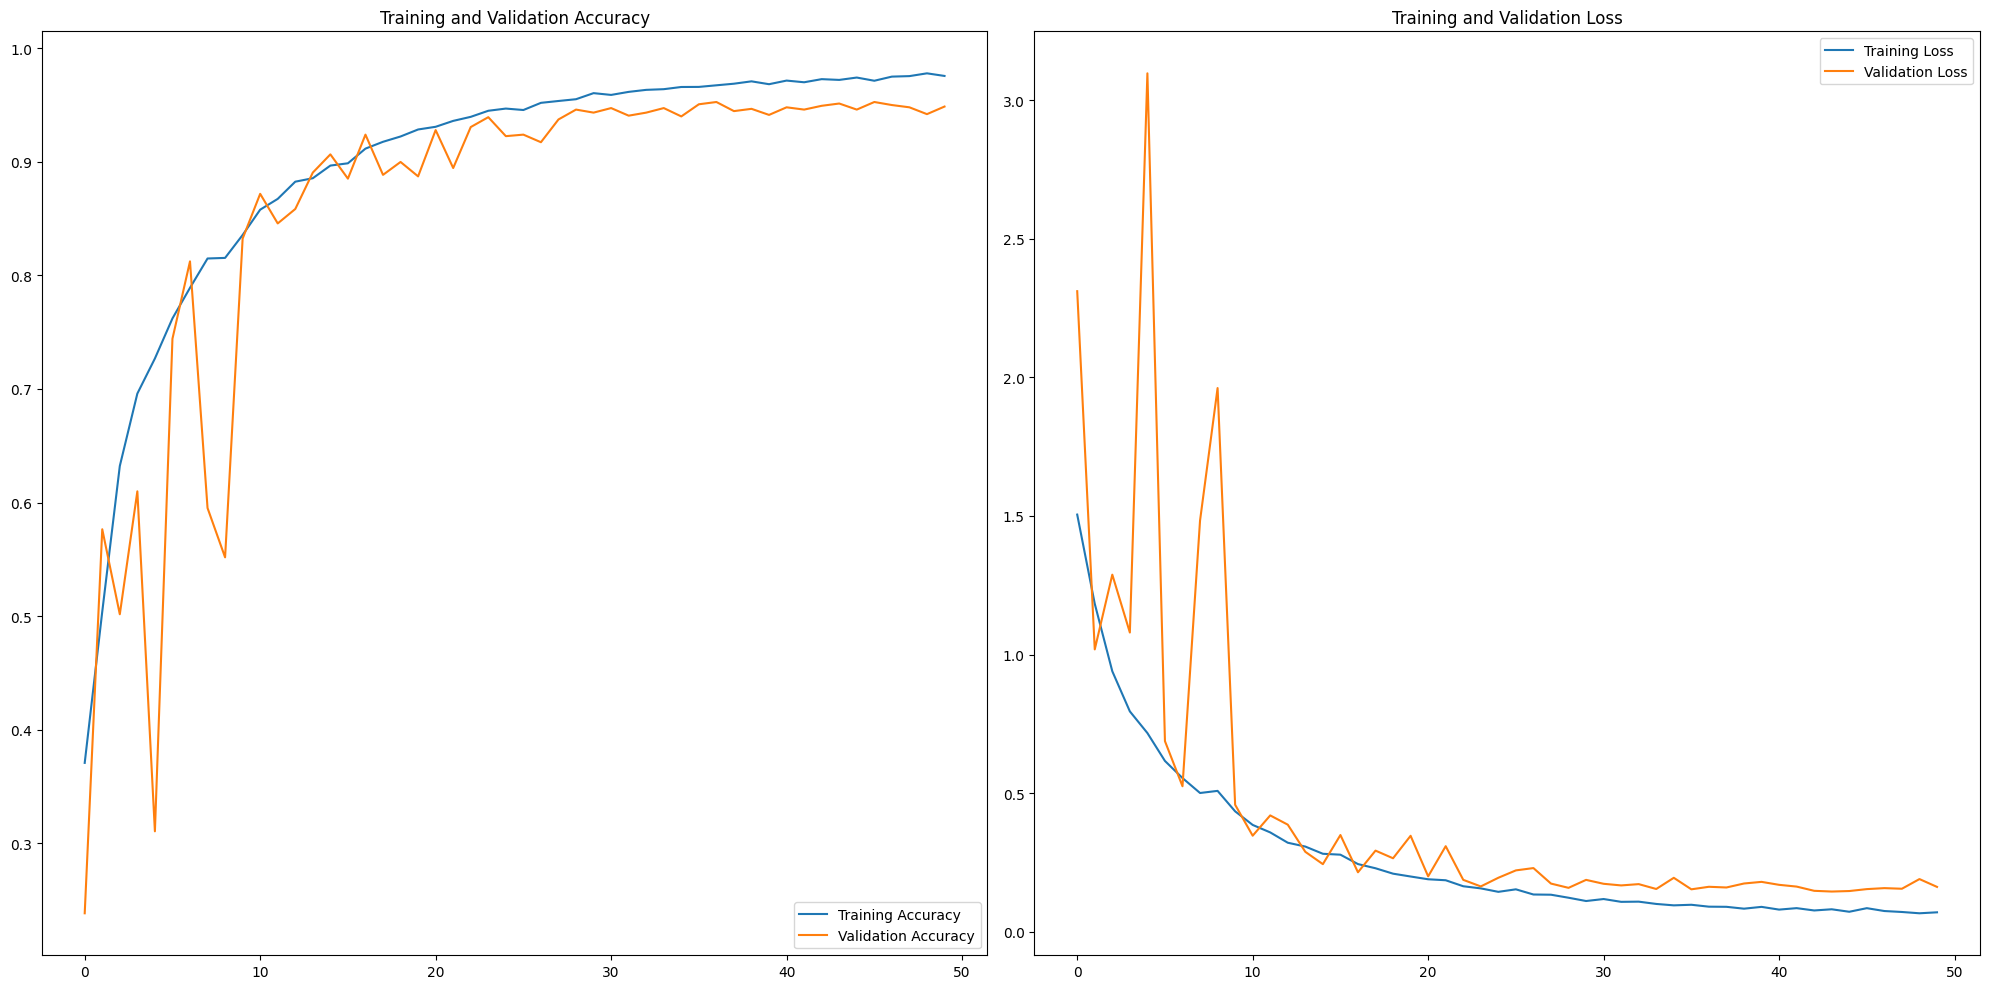

In [72]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.tight_layout()
plt.savefig('loss_and_accuracy.jpg')

plt.show()

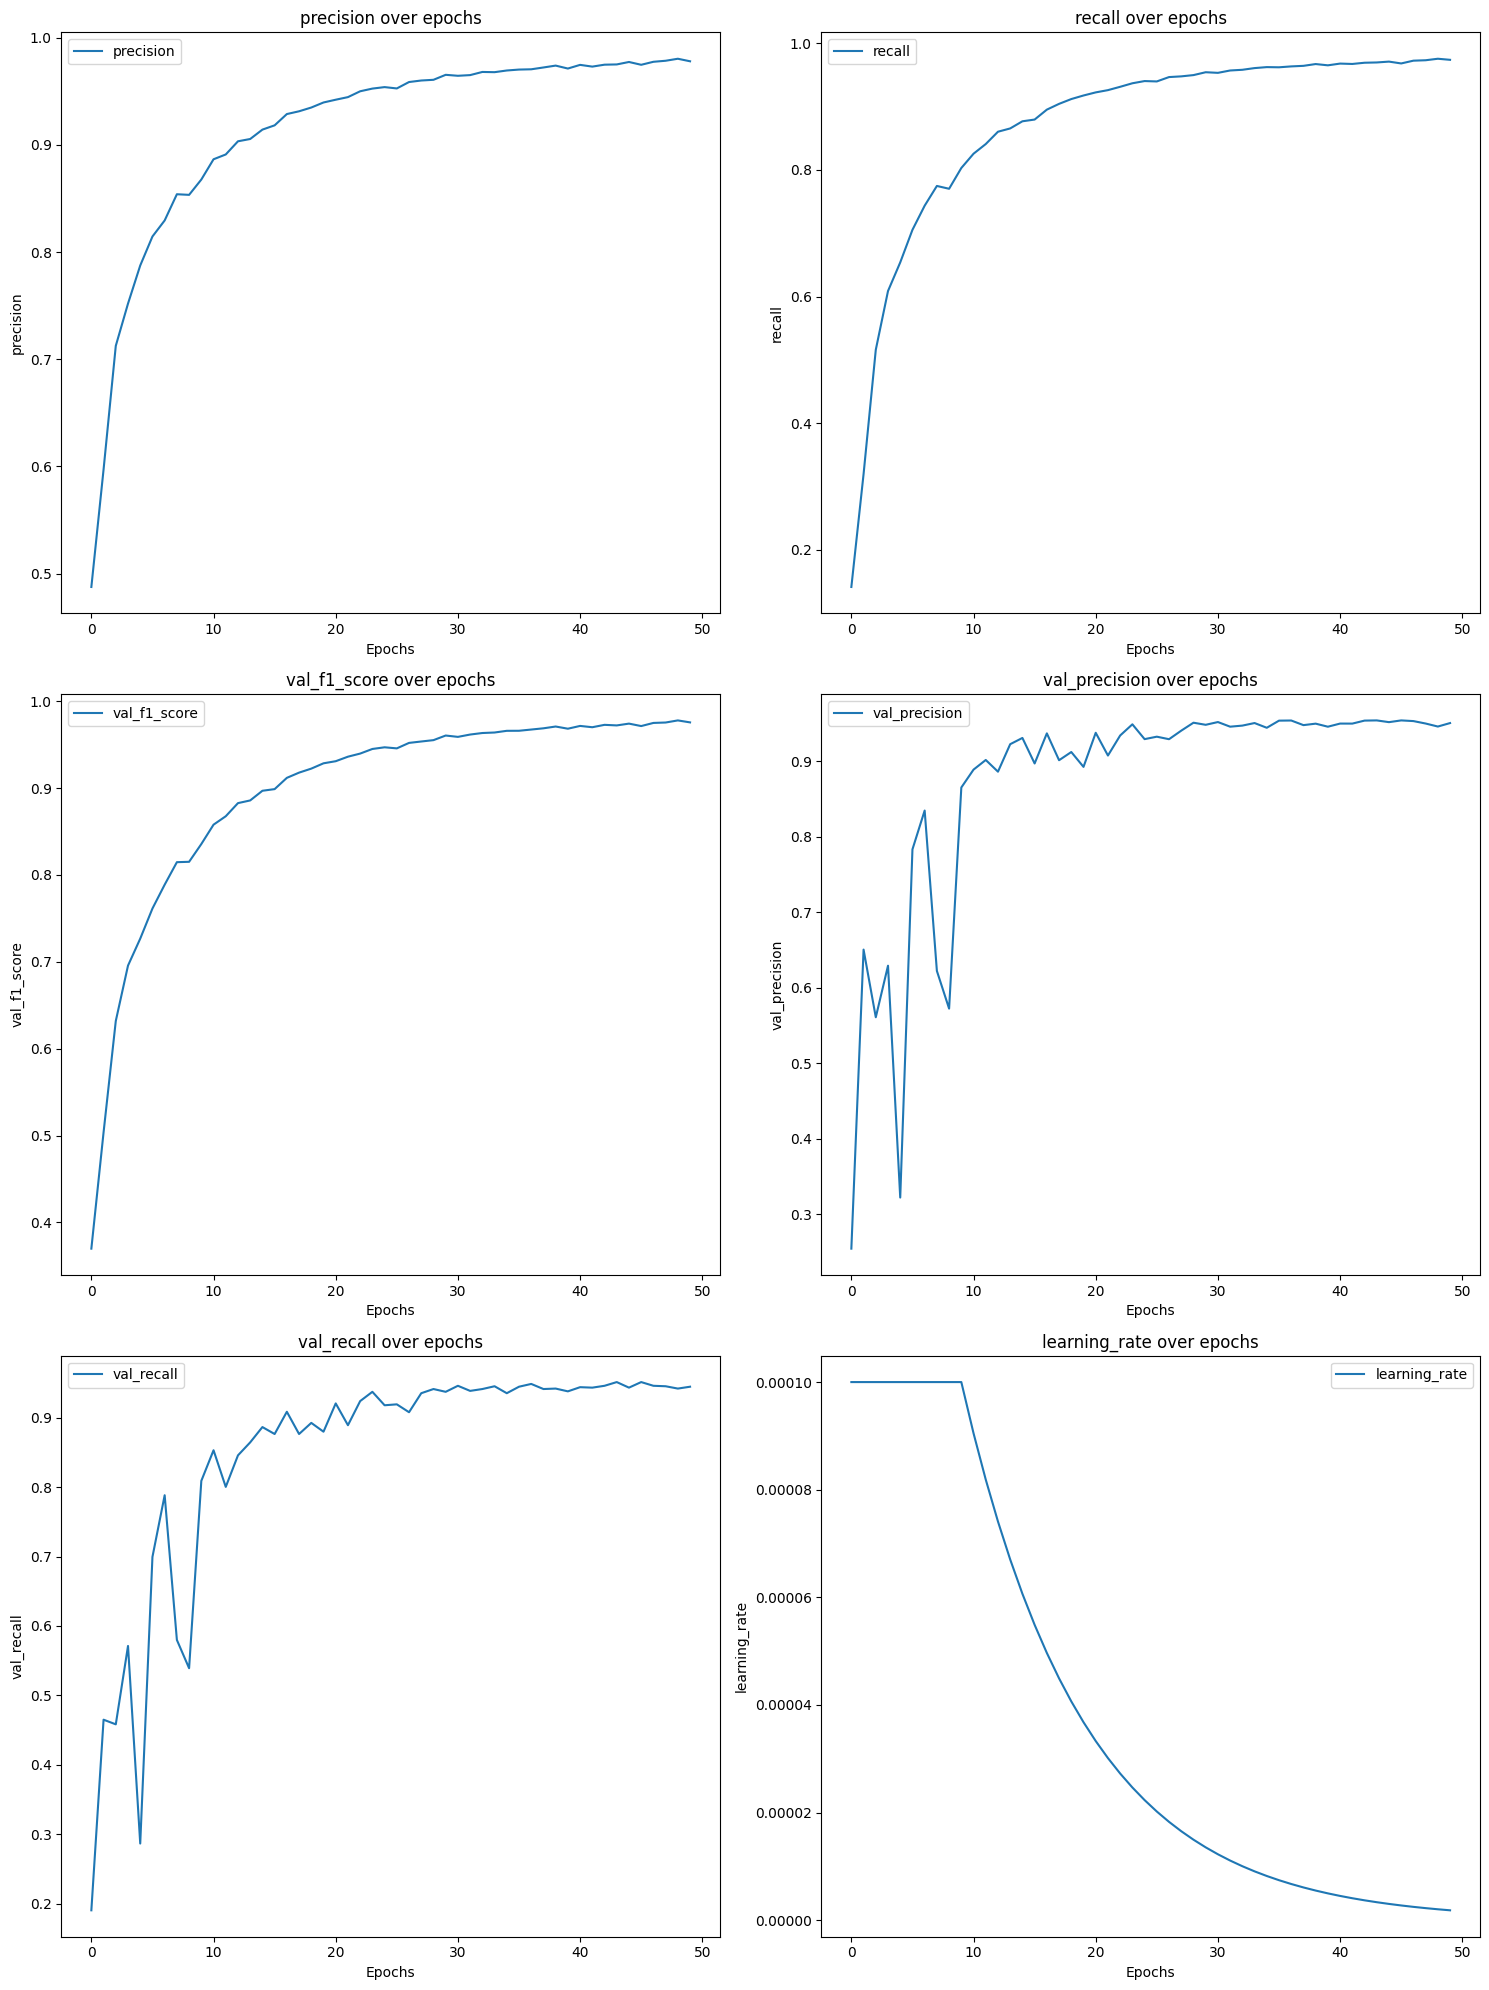

In [69]:
other_metrics_df = metrics_df.drop(columns = ['accuracy', 'val_accuracy', 'loss', 'val_loss'])
fig, axes = plt.subplots(nrows=len(other_metrics_df.columns)//2, ncols=2, figsize=(15, 20))
for i, column in enumerate(other_metrics_df.columns[1:]):
    ax = axes.flatten()[i]
    ax.plot(metrics_df[column], label=column)
    ax.set_title(f'{column} over epochs')
    ax.set_xlabel('Epochs')
    ax.set_ylabel(column)
    ax.legend()

plt.tight_layout()
plt.show()

In [75]:
loss, accuracy, f1_score, precision, recall = model.evaluate(validation_generator)
print("Loss: ", loss)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", 2*(precision*recall)/(precision+recall))

47/47 ━━━━━━━━━━━━━━━━━━━━ 5s 95ms/step - accuracy: 0.9471 - f1_score: 0.9480 - loss: 0.1721 - precision: 0.9506 - recall: 0.9471
Loss:  0.14402161538600922
Accuracy: 0.951235830783844
Precision: 0.9537843465805054
Recall: 0.951235830783844
F1 Score: 0.9525083839934677


In [68]:
evaluation

[0.14389552175998688,
 0.951235830783844,
 <tf.Tensor: shape=(5,), dtype=float32, numpy=
 array([0.9916247 , 0.98492455, 0.9250814 , 0.94039726, 0.91408926],
       dtype=float32)>,
 0.9537843465805054,
 0.951235830783844]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


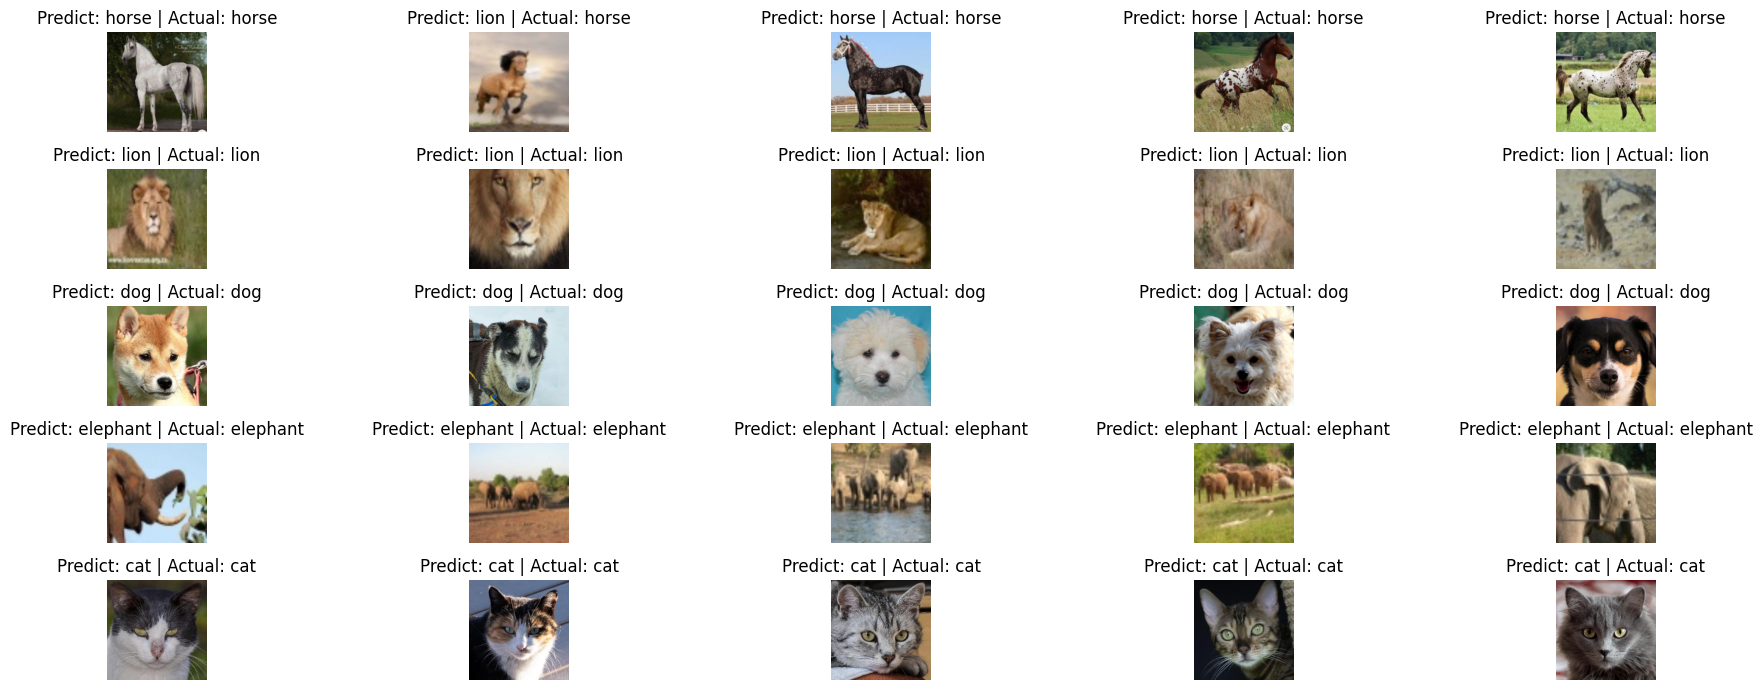

In [49]:
def predict(classes, model, base_path, num_images=5, save_fig_path=None):
    fig, axs = plt.subplots(len(classes), num_images, figsize=(20, 7))
    for i, class_name in enumerate(classes):
        class_path = os.path.join(base_path, class_name)
        image_files = os.listdir(class_path)
        random_images = random.sample(image_files, num_images)
        for j, image_file in enumerate(random_images):
            img_path = os.path.join(class_path, image_file)
            image = cv2.imread(img_path)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image = cv2.resize(image, (224, 224))
            image = np.array(image, dtype='float32') / 255.0
            image_to_predict = image.reshape(1, 224, 224, 3)
            prediction = model.predict(image_to_predict).argmax()
            
            label_names = train_generator.class_indices
            dict_class = dict(zip(list(range(len(label_names))), label_names))
            predicted_class_name = dict_class[prediction]
            
            axs[i, j].imshow(image)
            axs[i, j].set_title(f"Predict: {predicted_class_name} | Actual: {class_name}")
            axs[i, j].axis('off')
    plt.tight_layout()
    if save_fig_path is not None:
        plt.savefig(save_fig_path)
    plt.show()

predict(classes, model, VALIDATION_PATH_FOLDER, save_fig_path = 'prediction.jpg')